# Check list
1. 기존 시뮬레이션 방법 확인
2. Avg dtheta, theta사용해서 위치 확인하는것 확인
3. Avg dtheta 빠르게 구하는 방법

In [4]:
from parfor import parfor
import TO_sim.Integrator_jit as IJ
from TO_sim.Kuramoto_model import Kuramoto_2nd_mf,Kuramoto_1st_mf
from TO_sim.Q_simul import Q_Normal, Q_Lorentz
import numpy as np, matplotlib.pyplot as plt
from TO_sim.get_cluster import cluster_os_new2
import pandas as pd
RK4_jit_short = IJ.RK4_short

In [5]:
func = Kuramoto_2nd_mf
func1 = Kuramoto_1st_mf

In [ ]:
def assign_group_by_tolerance(df, tolerance):
    group_number = 0
    current_group_start = df['group abs rot'][0]  # 첫번째 값이 그룹의 시작 기준
    # 첫번째 값에 그룹 번호 할당
    df.at[0, 'Group'] = group_number
    
    # 두번째 값부터 확인하면서 그룹을 할당
    for i in range(1, len(df)):
        # 현재 값이 그룹 시작 값으로부터 tolerance 안에 있으면 같은 그룹으로 묶음
        if df['group abs rot'][i] - current_group_start <= tolerance:
            df.at[i, 'Group'] = group_number
        else:
            # 그룹 시작 값보다 tolerance를 벗어나면 새로운 그룹을 할당
            group_number += 1
            current_group_start = df['group abs rot'][i]  # 새로운 그룹 시작 값 갱신
            df.at[i, 'Group'] = group_number

    return df

def Get_Group(theta,t,L):
    th = (theta[-1]-theta[-L])//(np.pi*2)
    rs = np.abs(np.mean(np.exp(1j*theta[-L:]),axis=1))
    r = np.mean(rs)
    rstd = np.std(rs)
    th = th/(t[-1] - t[-L])
    bins = np.arange(-3-0.05,3,0.1)
    c,b = np.histogram(th,bins=bins)
    # c,b = np.histogram(th,bins=bins)
    c_sort = np.sort(c)[::-1]
    c_arg = np.argsort(c)[::-1]
    c_3, = np.where(c_sort>np.max(c)*(0.03))
    b_n0 = b[c_arg[c_3]]
    db = b[1] - b[0]

    N = len(theta[-1])
    gs = {}
    gs['group #'] = []
    gs['group rot'] = []
    gs['group idx'] = []
    if r>1/np.sqrt(N):
        num = 0
        for b_l in b_n0:
            if num == 0:
                idx, = np.where((th>=2*b_l)&(th<=b_l+2*db))
                gs['group idx'].append(idx)
                gs['group rot'].append(np.mean(th[idx])*(np.pi*2))
                gs['group #'].append(len(idx))
                num += 1
            else:
                idx, = np.where((th>=b_l)&(th<=b_l+db))
                gs['group idx'].append(idx)
                gs['group rot'].append(np.mean(th[idx])*(np.pi*2))
                gs['group #'].append(len(idx))
    df =  pd.DataFrame(gs)
    try:
        df['group abs rot'] = (df['group rot']-(df['group rot'].iloc[0]+df['group rot'].iloc[1])/2).apply(lambda x: np.abs(x))
        # if abs(df['group rot'].iloc[0])<0.3:
        df['group abs rot'] = (df['group rot']-(df['group rot'].iloc[0])).apply(lambda x: np.abs(x))
        # else:
            # df['group abs rot'] = (df['group rot']-(df['group rot'].iloc[0]+df['group rot'].iloc[1])/2).apply(lambda x: np.abs(x))
    except IndexError:
        df = pd.DataFrame()
        df[['group #','group rot','Group','g sign','r_m','r_std']] = None 
        columns = df.columns
        dat = [[N,None,'T',0,r,rstd]]
        df_S = pd.DataFrame(dat,columns=columns)
        df = pd.concat([df,df_S],axis=0)
        return df
    df = df.sort_values(by='group abs rot').reset_index(drop=True)
    df = assign_group_by_tolerance(df,0.1)
    def S_rho(x):
        L = len(x)
        a = theta[-L:,x]
        ST = np.sum(np.exp(a*1j),axis=1)
        rho = np.abs(ST/L)
        return rho
    df['rho_s'] = df['group idx'].apply(S_rho)
    df['r_m'] = df['rho_s'].apply(np.mean) * df['group #']/N
    df['r_std'] = df['rho_s'].apply(np.std) * df['group #']/N
    df['g sign'] = np.sign(df['group rot']) * np.sign(df['group abs rot'])
    df = df[['group #','group rot','Group','g sign','r_m','r_std']]
    columns = df.columns
    dat = [[N,None,'T',0,r,rstd]]
    df_S = pd.DataFrame(dat,columns=columns)
    df = pd.concat([df,df_S],axis=0)
    return df

In [4]:
Ks = np.linspace(0,15,30)

In [5]:
Ks[11]

5.689655172413794

In [103]:
seed =10
N = 2000
theta_random,omega,Kc = Q_Normal(N,0,1,seed=seed)
# theta_random,omega,Kc = Q_Lorentz(N,0,1,seed=seed)

omega = omega - np.mean(omega)
omega = np.sort(omega)
m = 4
dt = 0.1
t = np.arange(0,5000,dt)
# K = 5.5
L = 5000
to_ppi = lambda y: (y + np.pi)%(2*np.pi) - np.pi
# theta, dtheta,rs = mf2(K,N=N,m=m,t_array=t,p_theta=theta_random,p_dtheta=theta_random,p_omega=omega)
# plt.plot(np.sort(avg_dtheta[-1]))
# plt.plot((avg_dtheta[-1]))
Theta = np.r_[theta_random,omega]
Ks = np.arange(0,10+0.1/2,0.1)

In [33]:
sol = RK4_jit_short(func,Theta,t, args=(omega, N, m, K),result_time=int(t[-2000]/dt))

NameError: name 'K' is not defined

In [270]:
theta = sol[:,:N]

(-200.0, 200.0)

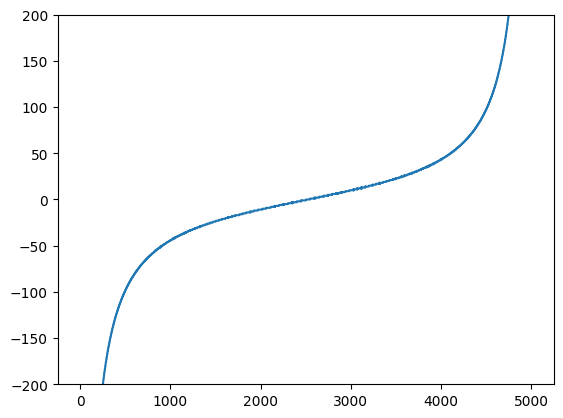

In [271]:
plt.plot((theta[-1]-theta[0])//(np.pi*2))
plt.ylim(-200,200)

In [215]:
bins = np.linspace(-100,100,1000)

In [321]:
Ks = np.linspace(0,15,31)

In [104]:
@parfor(Ks,bar=True)
def K_r(K):
    sol = RK4_jit_short(func1,Theta,t, args=(omega, N,0, K),result_time=int(t[-6000]/dt))
    theta = sol[:,:N]
    df = Get_Group(theta,t,L=N)
    return df

  0%|          | 0/101 [00:00<?, ?it/s]

In [ ]:
del K_r

In [105]:
Ks = np.round(Ks,2)
df_r = pd.DataFrame(index=np.round(Ks,2))
df_r[['rT','rTstd','0p','0m','0','1p','1m','2p','2m','3p','3m']] = None
for a,(K) in zip(K_r,Ks):
    df_r.loc[K,'rT'] = a[a['Group']=='T']['r_m'].values[0]
    df_r.loc[K,'rTstd'] = a[a['Group']=='T']['r_std'].values[0]
    for i in range(4):
        try:
            df_r.loc[K,f'{i}'] = a[(a['Group']==i)&(a['g sign']==0)]['r_m'].values[0]
        except:pass
        try:
            # print(a[(a['Group']==i)&(a['g sign']==1)]['r_m'].values[0])
            df_r.loc[K,f'{i}p'] = a[(a['Group']==i)&(a['g sign']==1)]['r_m'].values[0]
            df_r.loc[K,f'{i}m'] = a[(a['Group']==i)&(a['g sign']==-1)]['r_m'].values[0]
        except:pass



<Axes: >

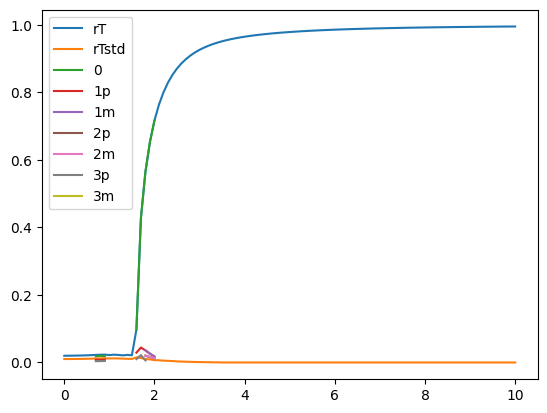

In [31]:
df_r.plot()

In [61]:
ROT = (theta[-1] - theta[0])//(2*np.pi) /(t[-6000] *0.1) * np.pi*2

NameError: name 'theta' is not defined

In [18]:
df_rN5000 = df_r['rT']

In [221]:
mean_dtheta = np.array([np.mean(dtheta[i:i+2000],axis=0) for i in range(10)])
# mean_dtheta2 = np.mean(dtheta[1:],axis=0)

In [1]:
from TO_sim.Get_2ndR_NORM import get_r_rp
from TO_sim.Get_2ndR_Lorentzian import get_r_rp as get_r_rL

In [2]:
m  = 0.1

F_rN = get_r_rp(m,0,K_len=401)
# F_rL = get_r_rL(m,0,K_max=15)

/Users/gugyoungkim/Desktop/Kuramoto/Kuramoto-model/TO_sim/Get_2ndR_NORM.py:156: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I_l,err = quad(integrand_Rl2, shift_O,+omega_p,args=(X,O_pm,shift_O,m),limit=200)
/Users/gugyoungkim/Desktop/Kuramoto/Kuramoto-model/TO_sim/Get_2ndR_NORM.py:157: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  I_d,err = quad(integrand_Rd2, omega_p,np.inf,args=(X,O_pm,shift_O,m),limit=200)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in F_sec (vectorized)
  outputs = ufunc(*inputs)


In [191]:
df_rN5000 = df_r['rT']


In [192]:
# np.savez('df_rN5000 m = 6 Normal distribution',df=df_rN5000,m=m)

In [193]:
df_rN = df_r['rT']


In [194]:
K_ = np.linspace(0,10,10000)

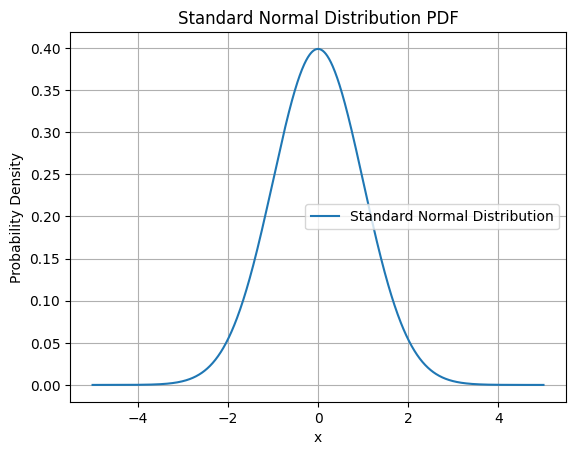

In [195]:
from scipy.stats import norm
import numpy as np

import matplotlib.pyplot as plt

# 표준 정규 분포의 x 값 범위 설정
x = np.linspace(-5, 5, 1000)

# 표준 정규 분포의 pdf 계산
pdf = norm.pdf(x)

# 그래프 그리기
plt.plot(x, pdf, label='Standard Normal Distribution')
plt.xlabel('x')
plt.ylabel('Probability Density')
plt.title('Standard Normal Distribution PDF')
plt.legend()
plt.grid(True)
plt.show()

In [196]:
from scipy.stats import norm
KcN = 2/(np.pi*norm.pdf(0))

In [3]:

# DD.plot(style='.-')
# plt.plot(df_rN,'s-')
plt.figure(dpi=1000)
plt.plot(K_,F_rN['R_u'](K_),color='gray',ls='-',lw=3)
plt.plot(df_rN5000,'.',color='red')
# plt.grid()
plt.axvline(KcN,ls=':',color='darkgray')
plt.text(KcN-0.5,0.8,'$K_c$',fontsize=15,color='gray')

# Ks_ = F_rN['Ks']
plt.ylim(0,1)
plt.xlim(0,10)
plt.xlabel('$K$',fontsize=15)
plt.ylabel('$r$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()
# plt.plot(K_,F_rN['R0_u'](K_))
# plt.plot(K_,F_rN['R_d'](K_))
# plt.plot(K_,(F_rN['R0_u'](K_)-F_rN['R_u'](K_))/2)

# plt.plot(Ks_,F_rN['r_+u'])
# plt.plot(Ks_,F_rN['r_+u'])
# plt.plot(Ks,r_su_l,'r-')
# plt.plot(Ks,r_su_l*2)

# plt.title(f'm = {m}',fontsize=15)

NameError: name 'plt' is not defined

In [198]:
df_rL = df_r['rT']

In [199]:

# DD.plot(style='.-')
# plt.plot(df_rN,'s-')
plt.figure(dpi=1000)
plt.plot(K_,F_rL['R_u'](K_),color='gray',ls='-',lw=3)
plt.plot(df_rL5000,'.',color='blue')
# plt.grid()
plt.axvline(Kc,ls=':',color='darkgray')
plt.text(Kc-0.5,0.8,'$K_c$',fontsize=15,color='gray')


# Ks_ = F_rN['Ks']
plt.ylim(0,1)
plt.xlim(0,10)
plt.xlabel('$K$',fontsize=15)
plt.ylabel('$r$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()
# plt.plot(K_,F_rN['R0_u'](K_))
# plt.plot(K_,F_rN['R_d'](K_))
# plt.plot(K_,(F_rN['R0_u'](K_)-F_rN['R_u'](K_))/2)

# plt.plot(Ks_,F_rN['r_+u'])
# plt.plot(Ks_,F_rN['r_+u'])
# plt.plot(Ks,r_su_l,'r-')
# plt.plot(Ks,r_su_l*2)

# plt.title(f'm = {m}',fontsize=15)

NameError: name 'F_rL' is not defined

<Figure size 6400x4800 with 0 Axes>

In [ ]:
# np.savez('single run/Lorentzian distiribution N = 500',df=df_rL,Ks=Ks)
# np.savez('single run/Lorentzian distiribution N = 5000',df=df_rL5000,Ks=Ks)
# np.savez('single run/Normal distiribution N = 5000',df=df_rN5000,Ks=Ks)
# np.savez('single run/Normal distiribution N = 500',df=df_rN,Ks=Ks)

In [ ]:
# np.load('single run/Lorentzian distiribution N = 5000.npz',allow_pickle=True)['df']

array([0.012432078055390395, 0.012372742314516039, 0.012300802638496122,
       0.01221706072100691, 0.012121883154146267, 0.012018906155174812,
       0.01191676212463321, 0.011823987873224556, 0.011748490212501385,
       0.011678228221511062, 0.011588440945427617, 0.011422971428227664,
       0.011373356746412653, 0.011509298699414788, 0.011386110017332729,
       0.011366288838361521, 0.012058011276318283, 0.012686346748288932,
       0.012679791100930073, 0.013655858561582773, 0.03200652428048534,
       0.2180780035804124, 0.3015483347043828, 0.3611775647239166,
       0.40827466089887987, 0.4471987921696005, 0.4804021526779041,
       0.5091759643318976, 0.5345568895153712, 0.5571200443002674,
       0.577370481969211, 0.5956852034651067, 0.6123810732548434,
       0.6276690957226404, 0.6417065438848728, 0.654665224553662,
       0.6666714050723597, 0.6777989039526457, 0.6881229980282924,
       0.6978355651221653, 0.706924308396578, 0.7154780437333168,
       0.7235287187289304

(0.0, 10.0)

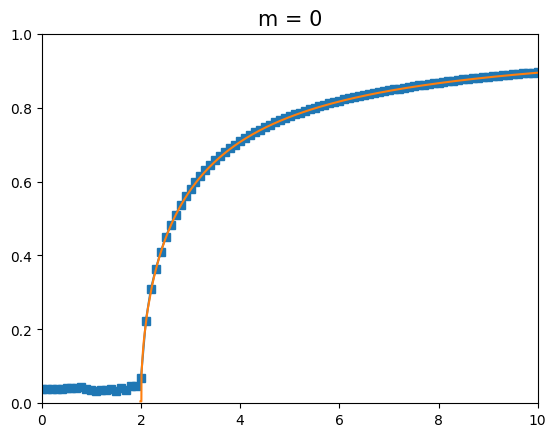

In [ ]:

# # DD.plot(style='.-')
# plt.plot(df_rL,'s-',zorder=2)
# # plt.grid()
# # plt.axvline(5.69)
# Ks_ = F_rL['Ks']
# plt.plot(K_,F_rL['R_u'](K_))
# # plt.plot(K_,F_rL['R0_u'](K_))
# # plt.plot(K_,F_rL['R_d'](K_))
# # plt.plot(K_,(F_rL['R0_u'](K_)-F_rL['R_u'](K_))/2)

# # plt.plot(Ks_,F_rL['r_+u'])
# # plt.plot(Ks_,F_rL['r_+u'])
# # plt.plot(Ks,r_su_l,'r-')
# # plt.plot(Ks,r_su_l*2)

# plt.title(f'm = {m}',fontsize=15)
# plt.ylim(0,1)
# plt.xlim(0,10)

In [ ]:
K_ = np.linspace(0,15,5000)

In [ ]:
sorted_df = df_r[['0p','0m','0','1p','1m','2p','2m','3p','3m']].fillna(0).apply(lambda row: sorted(row)[::-1], axis=1, result_type='expand')

/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_93853/3377626384.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  sorted_df = df_r[['0p','0m','0','1p','1m','2p','2m','3p','3m']].fillna(0).apply(lambda row: sorted(row)[::-1], axis=1, result_type='expand')


In [ ]:
DD = sorted_df.replace(0,np.nan)

<Axes: >

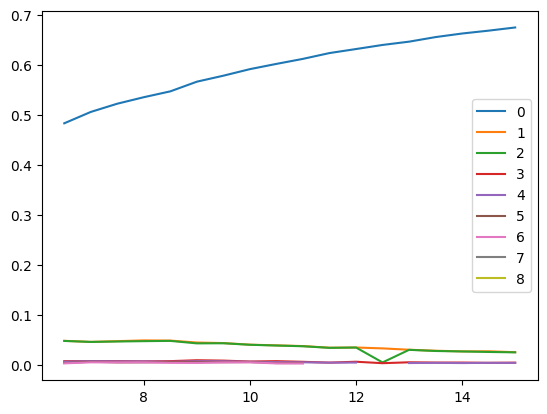

In [ ]:
DD.plot()

In [ ]:
Ks

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. ])

In [ ]:
df = pd.read_excel('N = 5000 seed = 10 QNORMAL wo pv.xlsm')

Text(0.5, 1.0, 'm = 4.0')

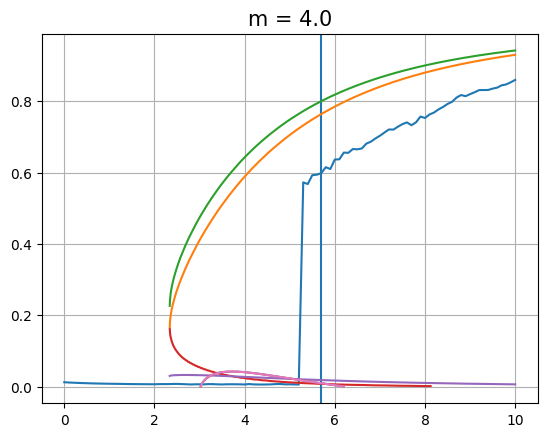

In [ ]:
# df_r[['0p','0m','0','1p','1m','2p','2m','3p','3m']].plot(style='.-')
# DD.plot(style='.-')
plt.plot(Ks,df[df.m==6]['rm'])
plt.grid()
plt.axvline(5.69)
Ks_ = F_rN['Ks']
plt.plot(K_,F_rN['R_u'](K_))
plt.plot(K_,F_rN['R0_u'](K_))
plt.plot(K_,F_rN['R_d'](K_))

plt.plot(K_,(F_rN['R0_u'](K_)-F_rN['R_u'](K_))/2)

plt.plot(Ks_,F_rN['r_+u'])
plt.plot(Ks_,F_rN['r_+u'])
# plt.plot(Ks,r_su_l,'r-')
# plt.plot(Ks,r_su_l*2)

plt.title(f'm = {m}',fontsize=15)

In [ ]:
df_R = pd.DataFrame(F_rN['r_+u'],index=Ks)

ValueError: Shape of passed values is (401, 1), indices imply (101, 1)

In [126]:
m

4.2

In [61]:
F_rN

{'R_u': <scipy.interpolate._interpolate.interp1d at 0x17937fcf0>,
 'R_d': <scipy.interpolate._interpolate.interp1d at 0x179850dc0>,
 'R0_u': <scipy.interpolate._interpolate.interp1d at 0x179f2e6c0>,
 'R0_d': <scipy.interpolate._interpolate.interp1d at 0x1798521c0>,
 'Ks': array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
         0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
         0.9 ,  0.95,  1.  ,  1.05,  1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,
         1.35,  1.4 ,  1.45,  1.5 ,  1.55,  1.6 ,  1.65,  1.7 ,  1.75,
         1.8 ,  1.85,  1.9 ,  1.95,  2.  ,  2.05,  2.1 ,  2.15,  2.2 ,
         2.25,  2.3 ,  2.35,  2.4 ,  2.45,  2.5 ,  2.55,  2.6 ,  2.65,
         2.7 ,  2.75,  2.8 ,  2.85,  2.9 ,  2.95,  3.  ,  3.05,  3.1 ,
         3.15,  3.2 ,  3.25,  3.3 ,  3.35,  3.4 ,  3.45,  3.5 ,  3.55,
         3.6 ,  3.65,  3.7 ,  3.75,  3.8 ,  3.85,  3.9 ,  3.95,  4.  ,
         4.05,  4.1 ,  4.15,  4.2 ,  4.25,  4.3 ,  4.35,  4.4 ,  4.45,
         4.5 ,  4.

In [80]:
df[df.m==6]['rm']-df[df.m==6]['sig']

60       0.005750
161      0.005455
262      0.005181
363      0.004919
464      0.004665
           ...   
9756     0.779797
9857     0.792068
9958     0.790361
10059    0.795148
10160    0.796775
Length: 101, dtype: float64

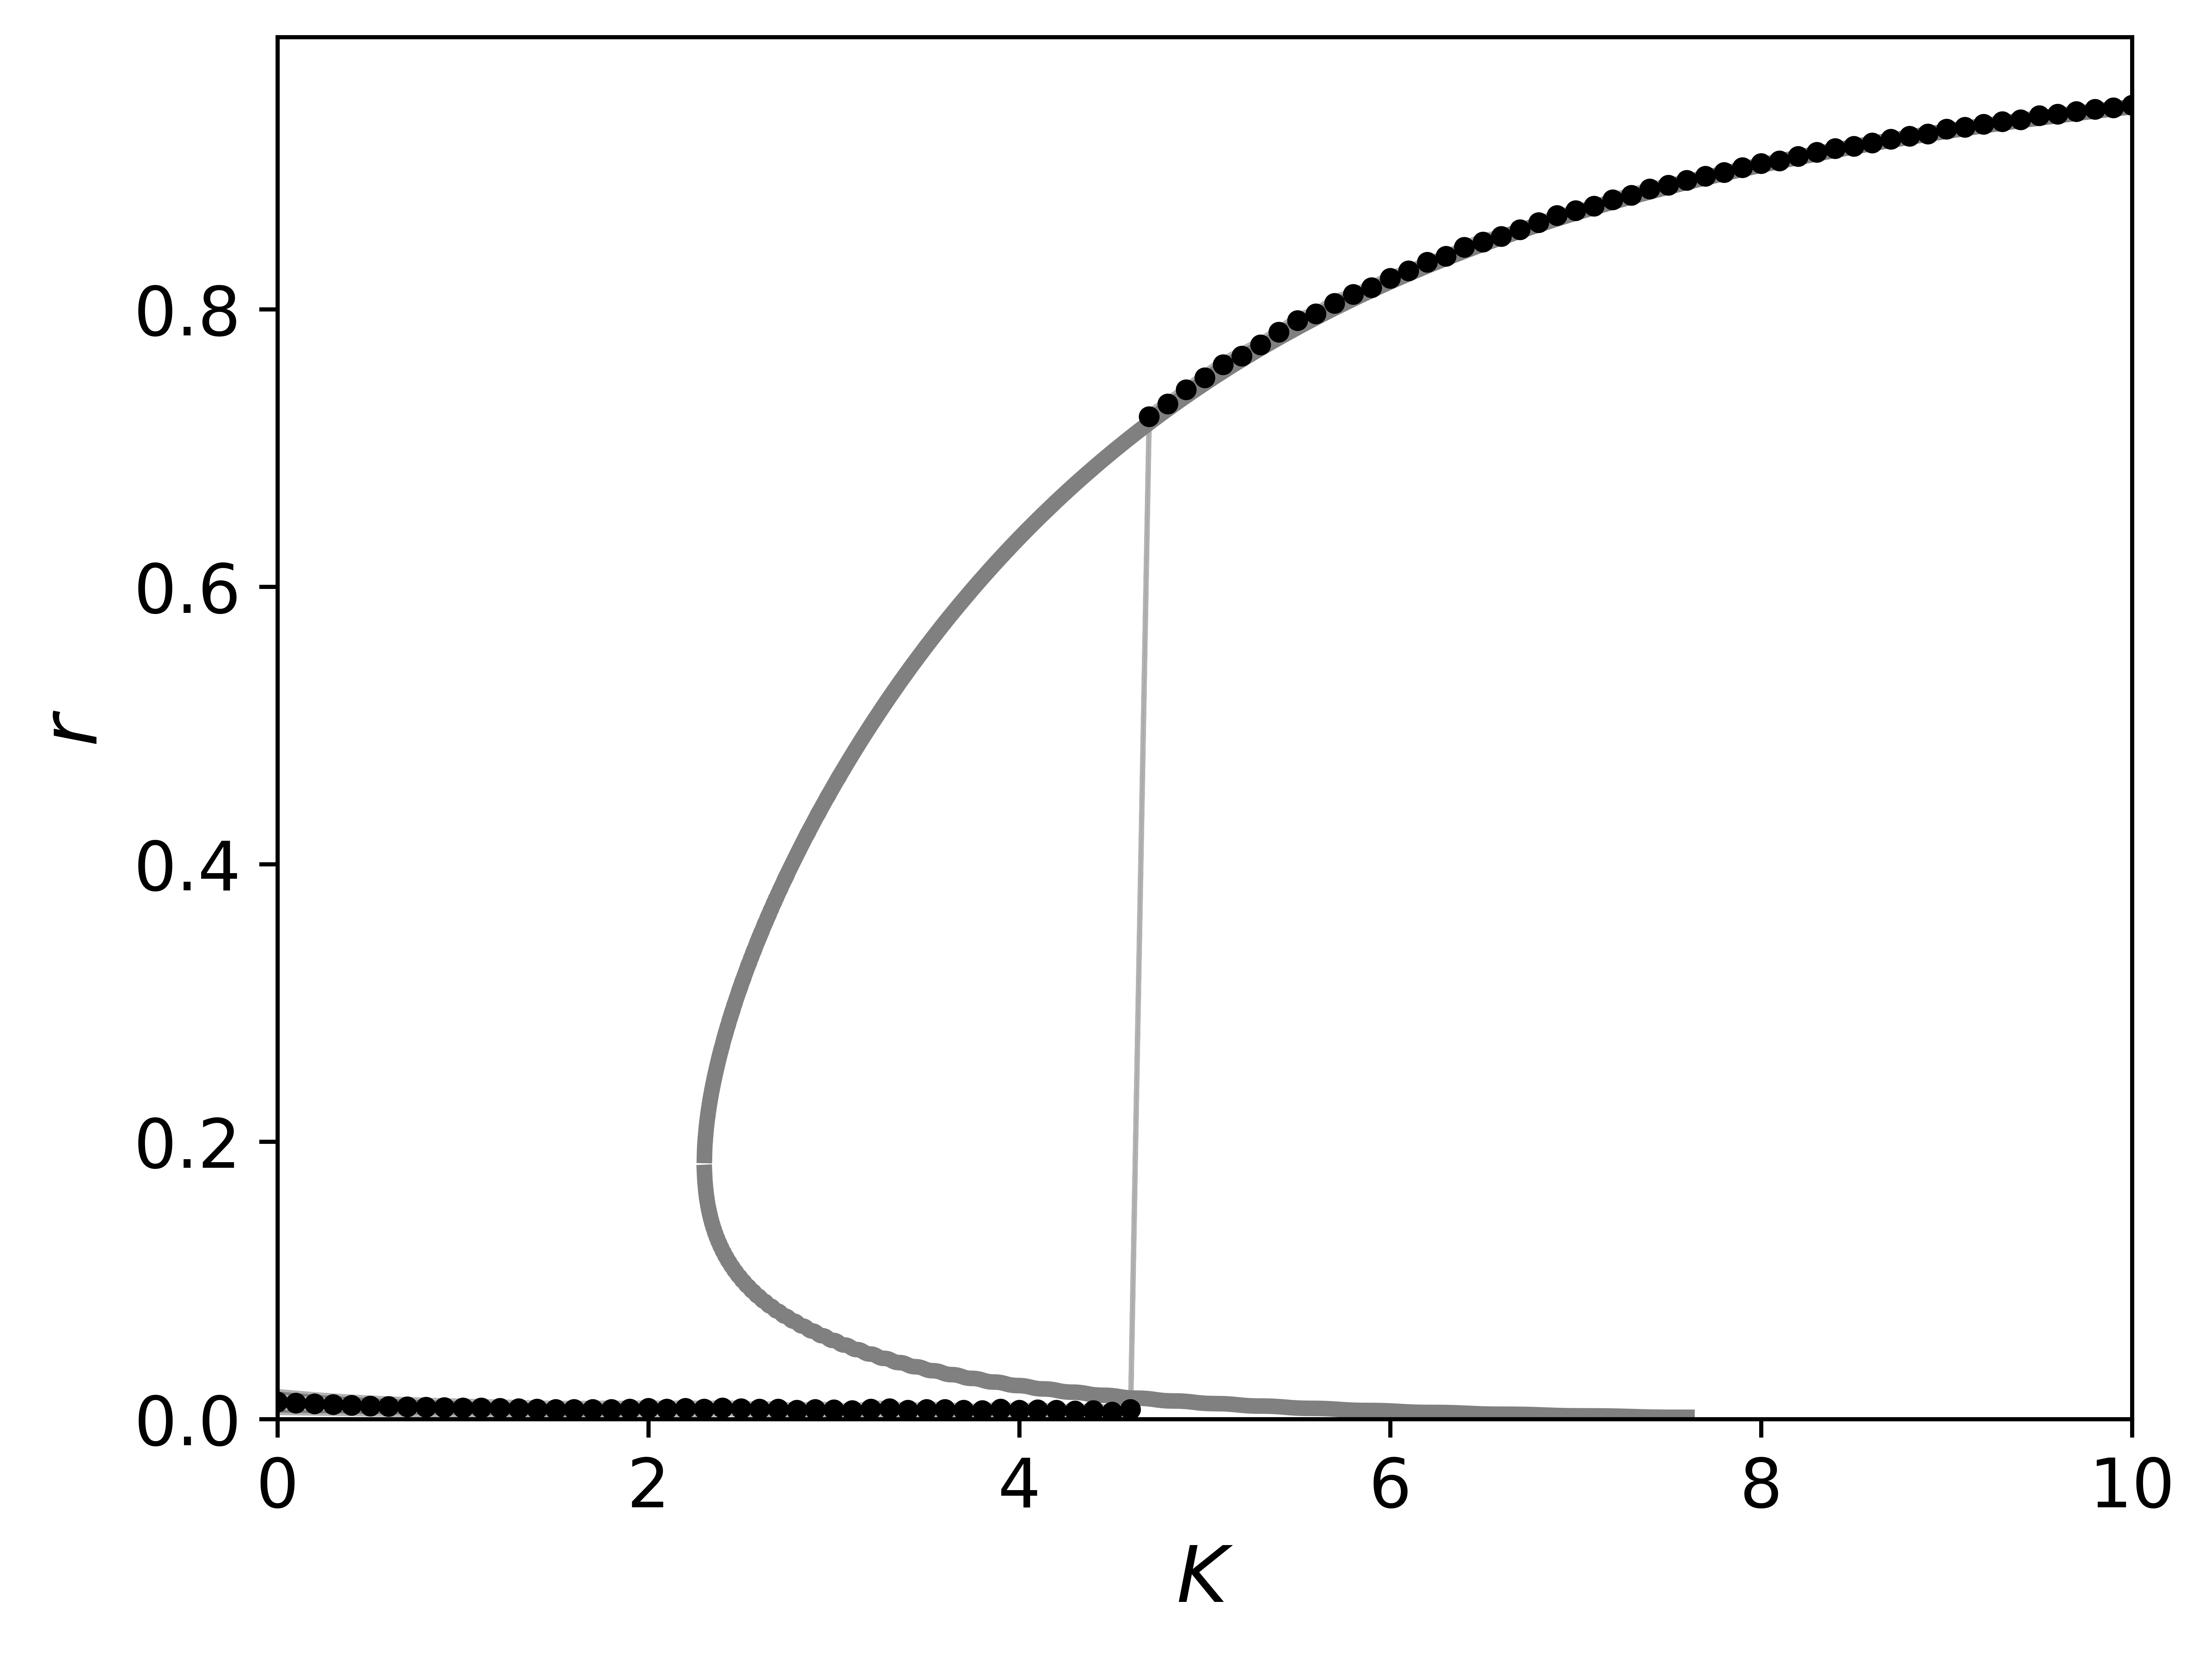

In [ ]:

# DD.plot(style='.-')
# plt.plot(df_rN,'s-')
plt.figure(dpi=1000)
# plt.subplot(211)
# plt.plot(K_,F_rN['R0_u'](K_),color='gray',ls='-',lw=3)
plt.plot(K_,F_rN['R_u'](K_),color='gray',ls='-',lw=3)
plt.plot(K_,F_rN['R_d'](K_),color='gray',ls='-',lw=3)
# plt.plot(F_rN['Ks'],F_rN['r_+d'],color='gray',ls='-',lw=3)
plt.plot(Ks,df[df.m==m]['rm'].to_numpy(),'.',color='black')
plt.fill_between(Ks,df[df.m==m]['rm']-df[df.m==m]['sig'],df[df.m==m]['rm']+df[df.m==m]['sig'],color='black',alpha=0.3)
# plt.plot(Ks,df[df.m==6]['r-'],'.-',color='red')
plt.ylim(0,)
plt.xlim(0,10)
# plt.xlabel('$K$',fontsize=15)
plt.ylabel('$r$',fontsize=15)
plt.xlabel('$K$',fontsize=15)

plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
# plt.ylabel('$r_{+},r_{-}$',fontsize=15)
# plt.xticks(fontsize=13)
# plt.yticks(fontsize=13)

plt.show()

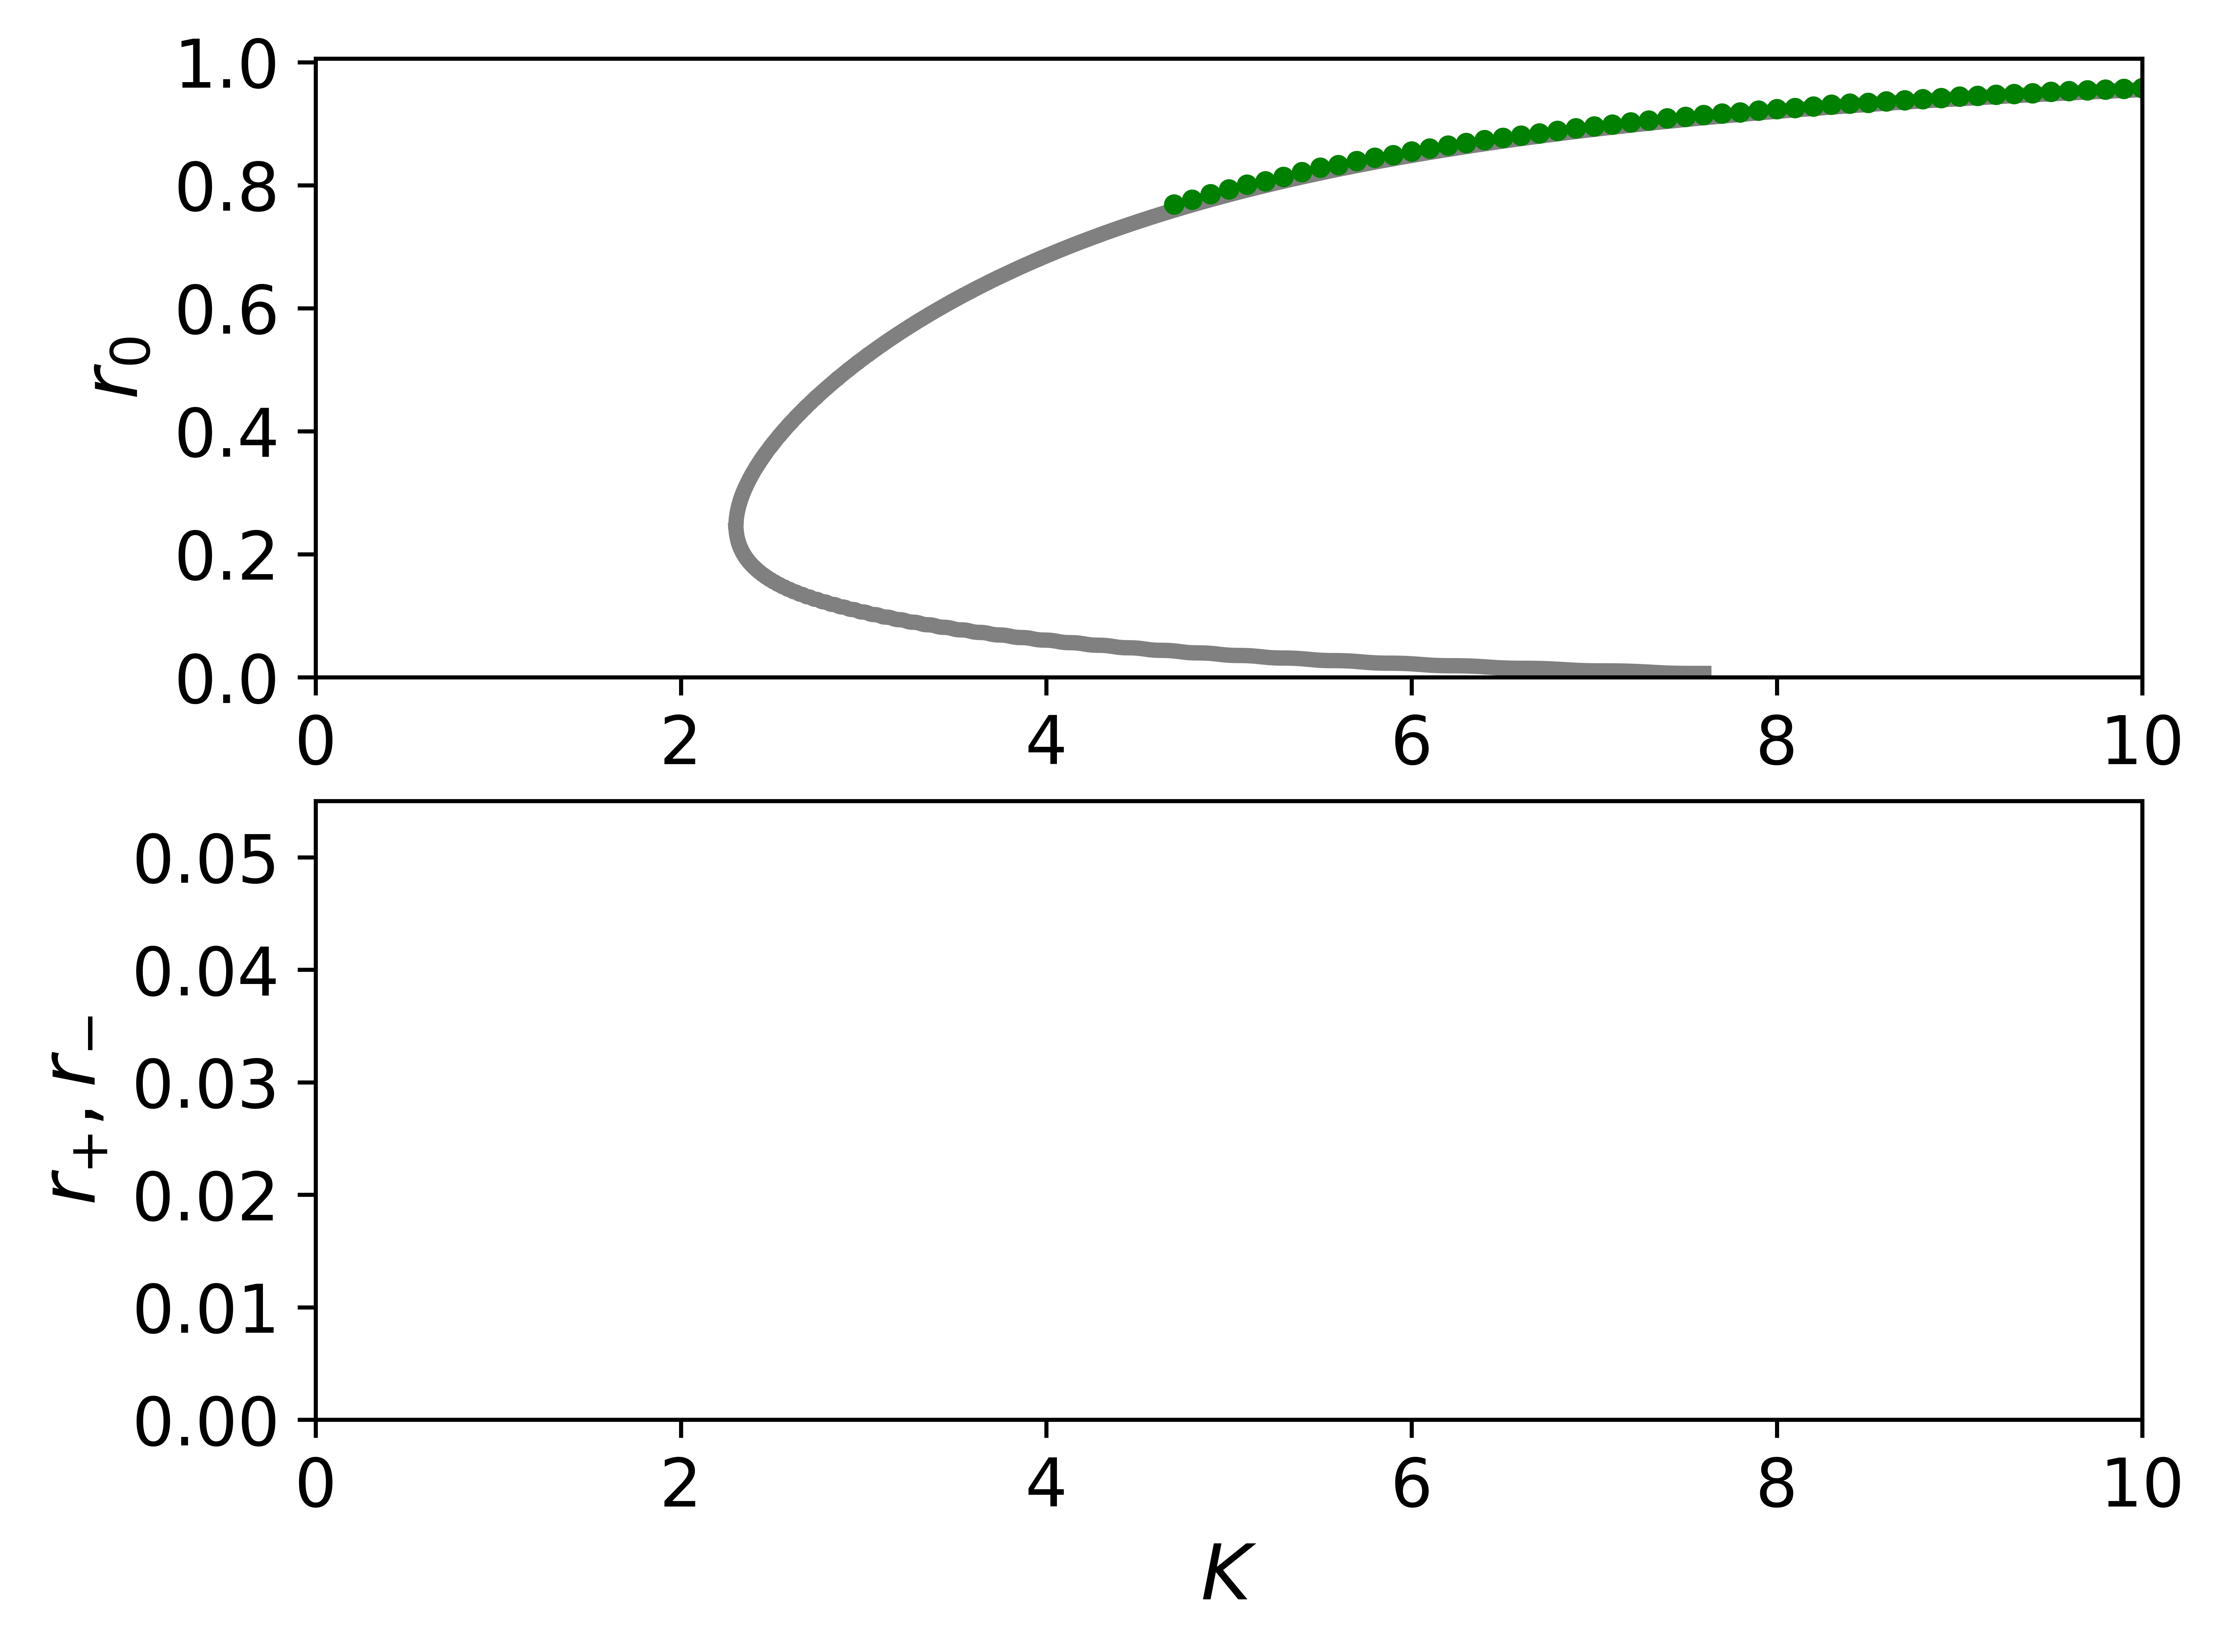

In [ ]:

# DD.plot(style='.-')
# plt.plot(df_rN,'s-')
plt.figure(dpi=1000)
plt.subplot(211)
# plt.plot(K_,F_rN['R0_u'](K_),color='gray',ls='-',lw=3)
plt.plot(K_,F_rN['R0_u'](K_),color='gray',ls='-',lw=3)
plt.plot(K_,F_rN['R0_d'](K_),color='gray',ls='-',lw=3)
# plt.plot(F_rN['Ks'],F_rN['r_+d'],color='gray',ls='-',lw=3)
plt.plot(Ks,df[df.m==m]['r0'],'.-',color='green')
# plt.plot(Ks,df[df.m==6]['r-'],'.-',color='red')
plt.ylim(0,)
plt.xlim(0,10)
# plt.xlabel('$K$',fontsize=15)
plt.ylabel('$r_{0}$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)


plt.subplot(212)
# plt.plot(K_,F_rN['R0_u'](K_),color='gray',ls='-',lw=3)
plt.plot(F_rN['Ks'],F_rN['r_+u'],color='gray',ls='-',lw=3)
plt.plot(F_rN['Ks'],F_rN['r_+d'],color='gray',ls='-',lw=3)
plt.plot(Ks,df[df.m==m]['r+'],'.-',color='blue')
plt.plot(Ks,df[df.m==m]['r-'],'.-',color='red')
plt.ylim(0,)
plt.xlim(0,10)
plt.xlabel('$K$',fontsize=15)
plt.ylabel('$r_{+},r_{-}$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)

plt.show()

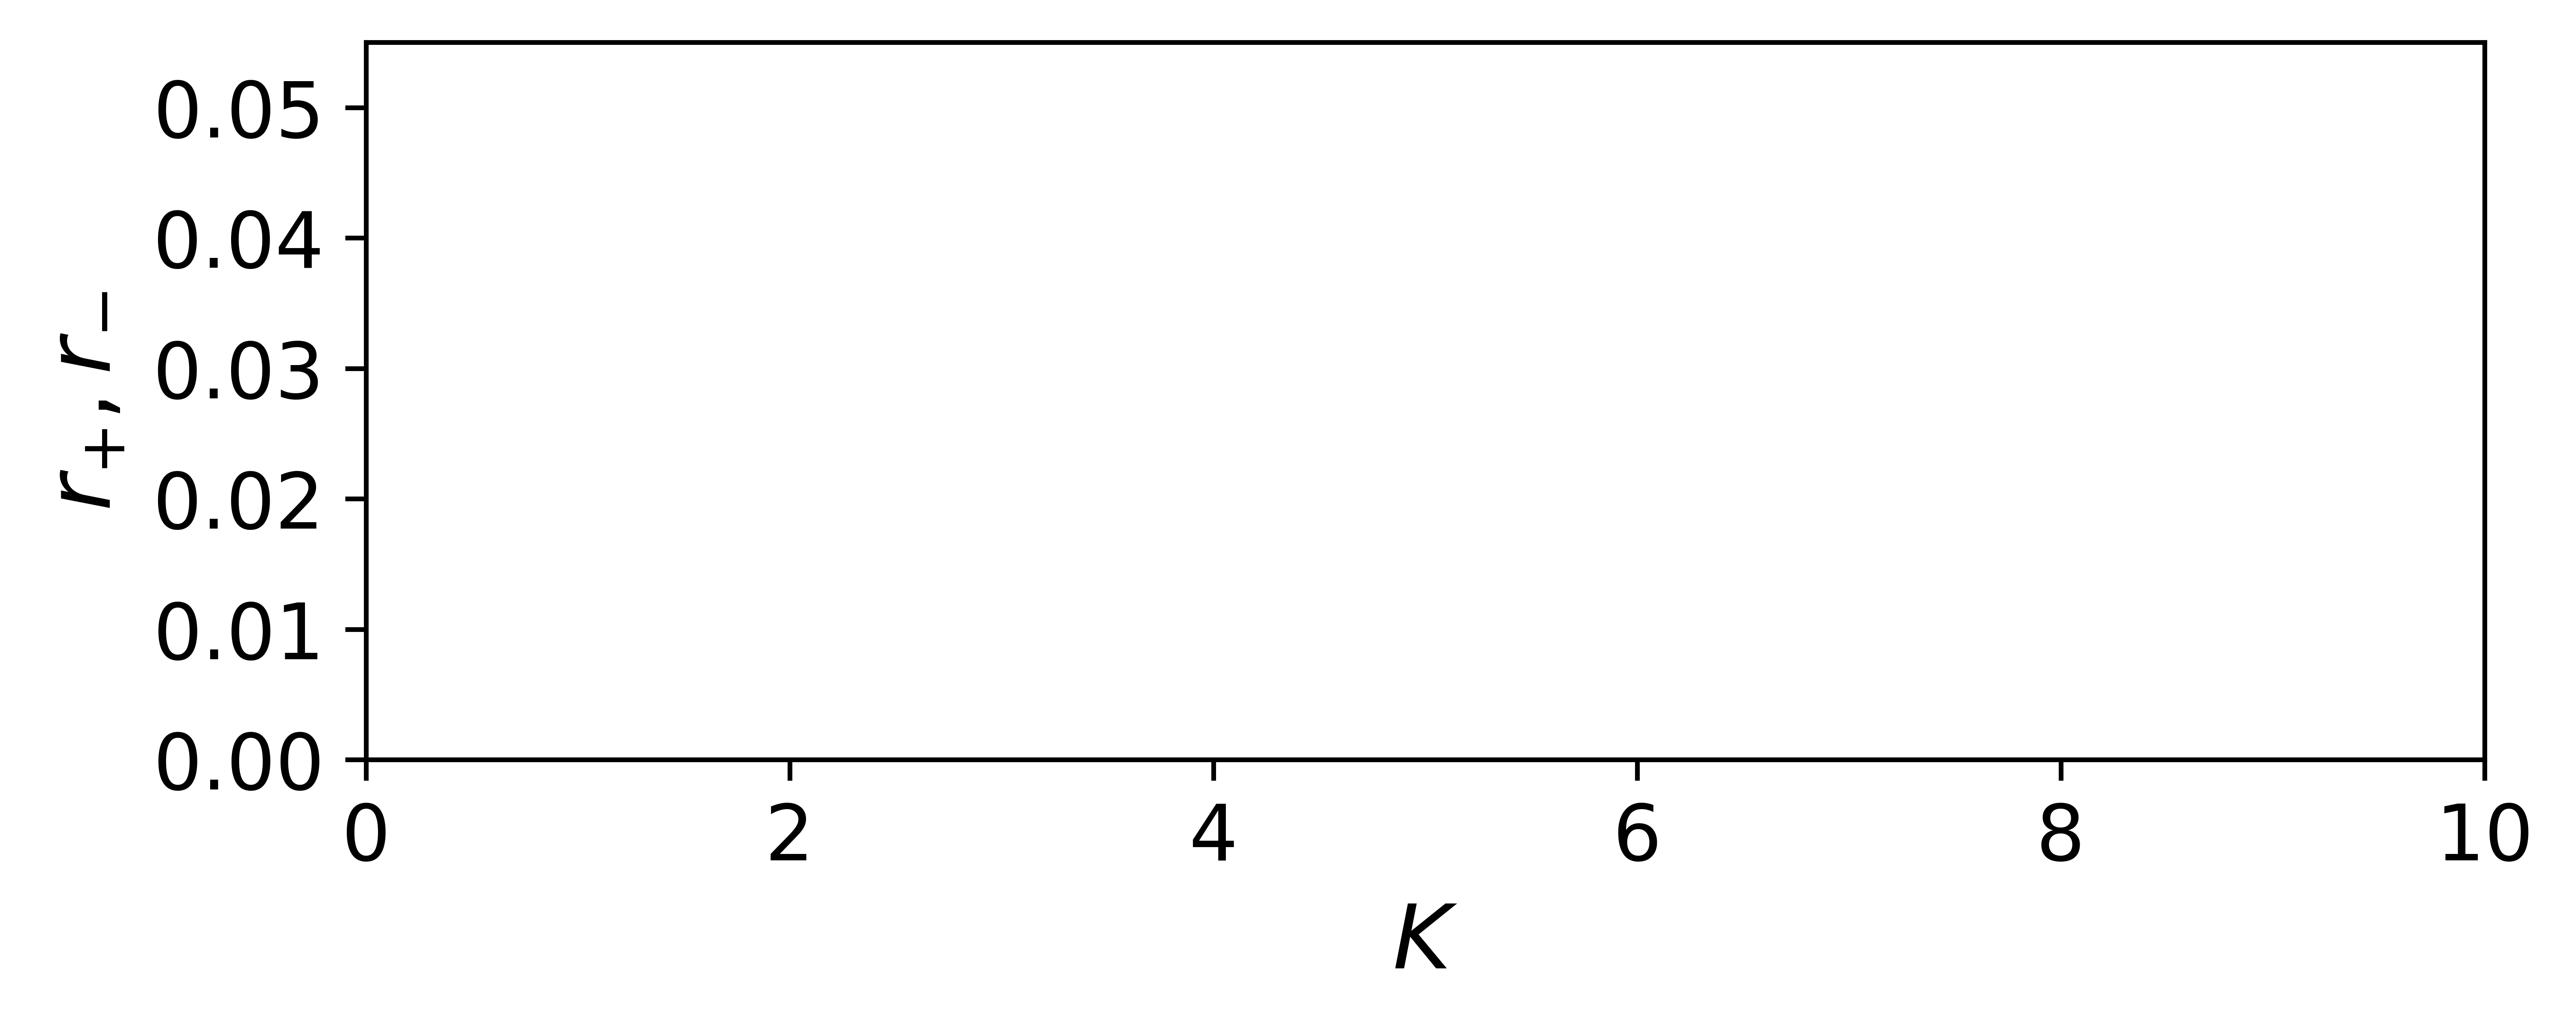

In [ ]:

# DD.plot(style='.-')
# plt.plot(df_rN,'s-')
plt.figure(dpi=1000)
plt.subplot(211)
# plt.plot(K_,F_rN['R0_u'](K_),color='gray',ls='-',lw=3)
plt.plot(F_rN['Ks'],F_rN['r_+u'],color='gray',ls='-',lw=3)
plt.plot(F_rN['Ks'],F_rN['r_+d'],color='gray',ls='-',lw=3)
plt.plot(Ks,df[df.m==m]['r+'],'.-',color='blue')
plt.plot(Ks,df[df.m==m]['r-'],'.-',color='red')
plt.ylim(0,)
plt.xlim(0,10)
plt.xlabel('$K$',fontsize=15)
plt.ylabel('$r_{+},r_{-}$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.show()

In [ ]:
def get_sig(F_r,m):
    F_RM = F_r['R_u']
    F_R0 = F_r['R0_u']
    K = F_r['Ks']
    O_pm = 4/np.pi*np.sqrt(K*F_RM(K)/m) - 0.3056/np.sqrt(K*F_RM(K)*m**3)
    rp =F_r['r_+u']
    r0 = F_R0(K)
    sig = 2*rp*np.sqrt(1/2 - m*K*r0/(4*(4*m**2*O_pm**2 +1)) - (m*K*r0/(2*(m**2*O_pm**2+1))**2))
    return sig

def get_sig_d(F_r,m):
    F_RM = F_r['R_d']
    F_R0 = F_r['R0_d']
    K = F_r['Ks']
    O_pm = 4/np.pi*np.sqrt(K*F_RM(K)/m) - 0.3056/np.sqrt(K*F_RM(K)*m**3)
    rp =F_r['r_+d']
    r0 = F_R0(K)
    sig = 2*rp*np.sqrt(1/2 - m*K*r0/(4*(4*m**2*O_pm**2 +1)) - (m*K*r0/(2*(m**2*O_pm**2+1))**2))
    return sig

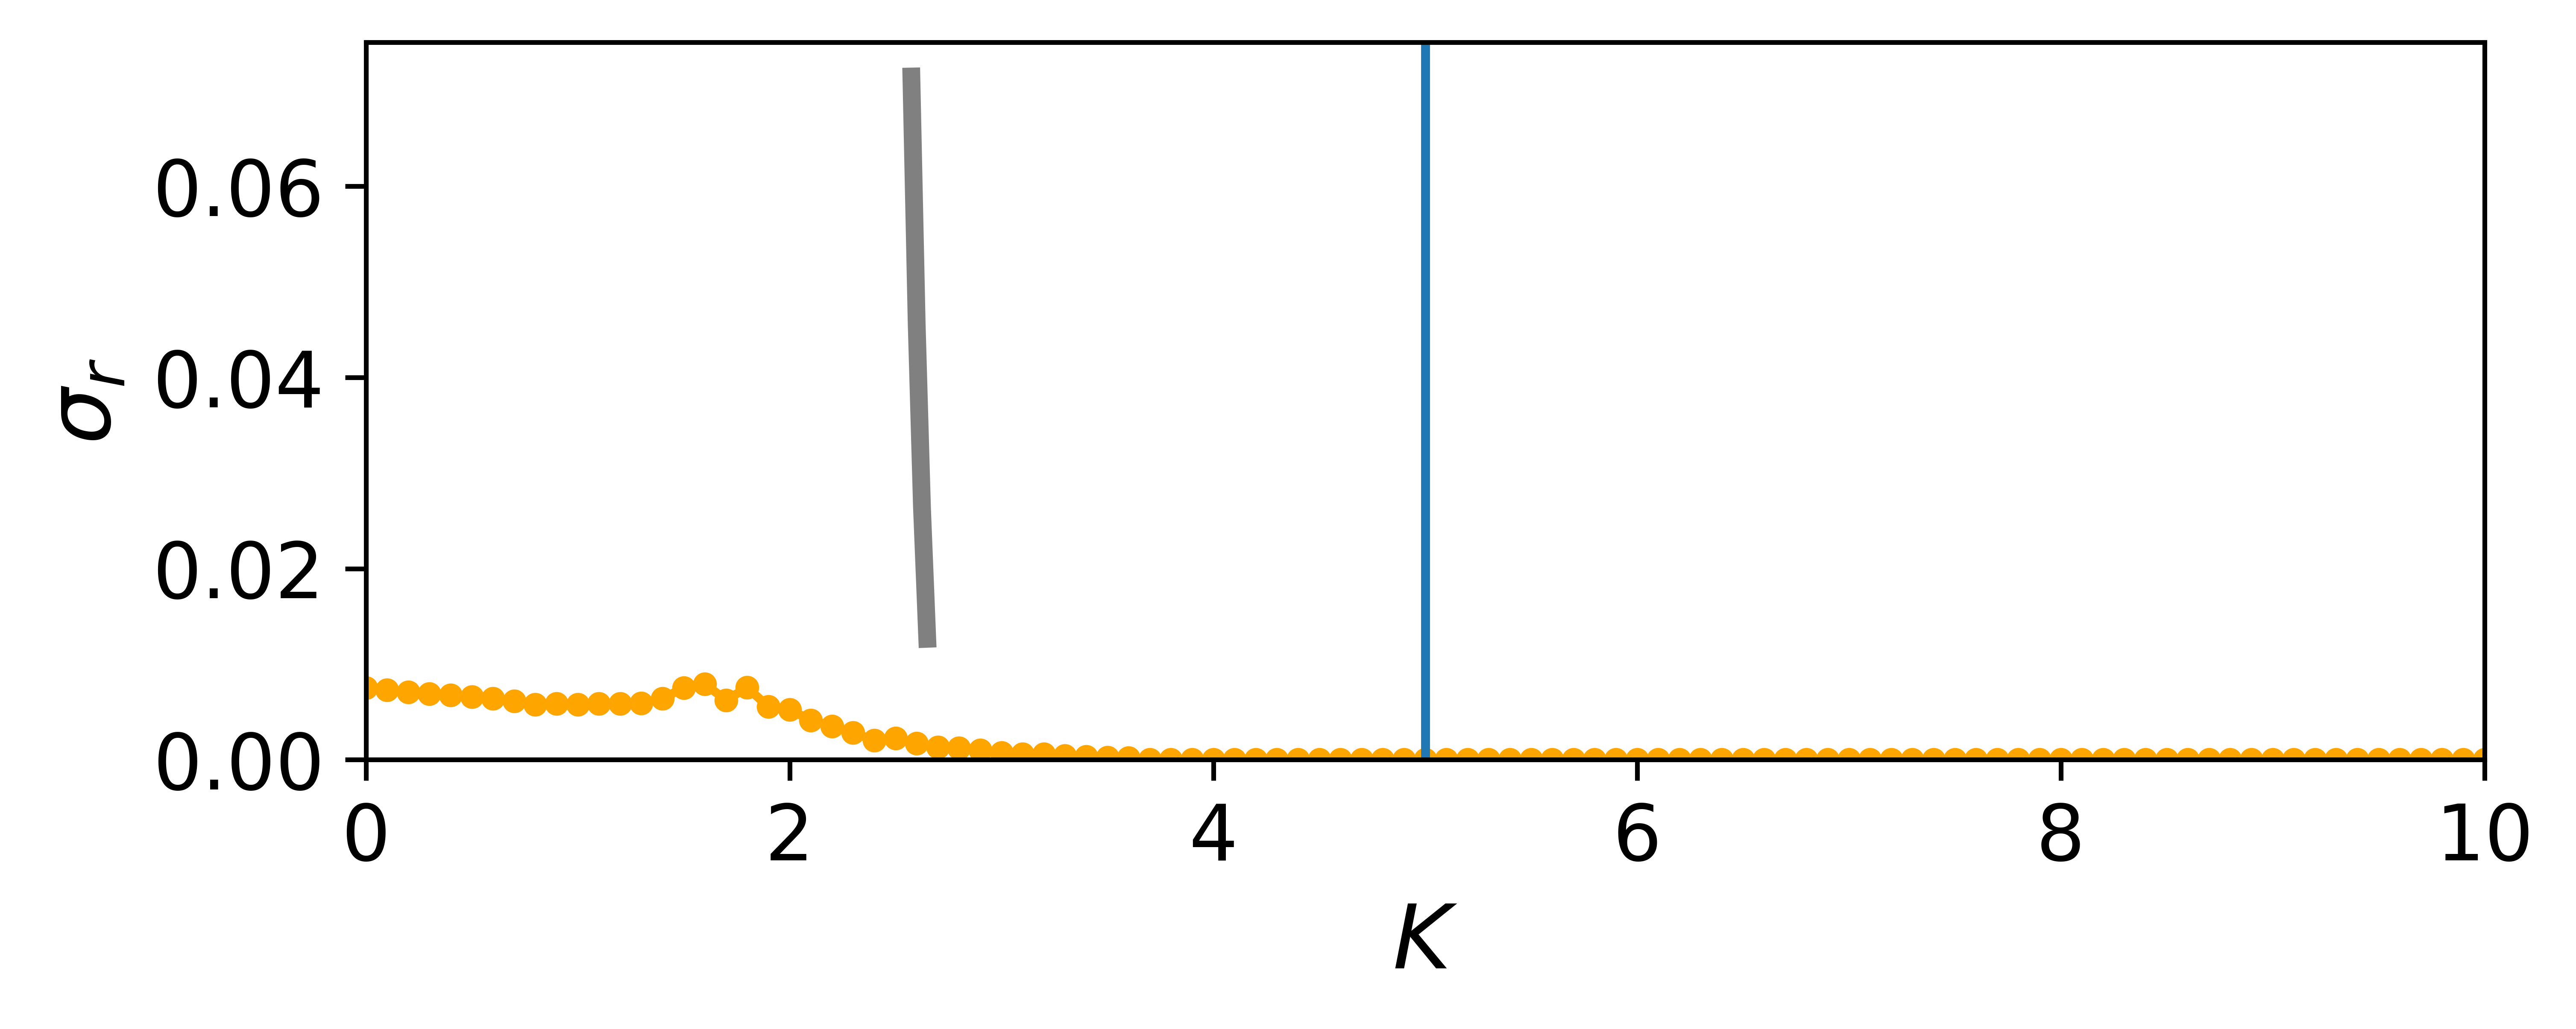

In [200]:
plt.figure(dpi=1000)
plt.subplot(211)
# plt.plot(K_,F_rN['R0_u'](K_),color='gray',ls='-',lw=3)
plt.plot(F_rN['Ks'],get_sig(F_rN,m),color='gray',ls='-',lw=3)
plt.plot(F_rN['Ks'],get_sig_d(F_rN,m),color='gray',ls='-',lw=3)
# plt.plot(Ks,df[df.m==6]['r+'],'.-',color='blue')
plt.plot(Ks,df[df.m==m]['sig'],'.-',color='orange')
plt.ylim(0,)
plt.xlim(0,10)
plt.xlabel('$K$',fontsize=15)
plt.ylabel('$\sigma_{r}$',fontsize=15)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.axvline(5)

plt.show()

In [92]:
F_rN['R0_u']